In [1]:
# datos de la api 
#!pip install quandl
#import quandl
#quandl.ApiConfig.api_key = 'zN76FTAvaQHApJxnJVTb'
#def get_info_bit(start, end, key):
#    inf = quandl.get(key, start_date = start,end_date = end)
#    return inf
#quandl.get('BCHAIN/MKPRB', start_date = '2018-11-01',end_date = '2020-11-01')

# Lectura de datos

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('./data/oro.csv')
df.head()

,Fecha,Cierre,Apertura,Máximo,Mínimo,Vol.,% var.
0,15.01.2021,"1,851.80","1,846.70","1,855.60","1,846.10",-,0.02%
1,14.01.2021,"1,851.40","1,845.60","1,857.60","1,826.60",-,-0.19%
2,13.01.2021,"1,854.90","1,855.00","1,863.00","1,841.60",225.99K,0.58%
3,12.01.2021,"1,844.20","1,845.40","1,864.00","1,835.80",240.66K,-0.36%
4,11.01.2021,"1,850.80","1,849.40","1,856.00","1,817.10",268.36K,0.84%


In [4]:
df = pd.read_csv('./data/BCHAIN-MKPRU.csv')
df.head()

,Date,Value
0,2021-01-16,39158.47
1,2021-01-15,37393.13
2,2021-01-14,34011.82
3,2021-01-13,35544.94
4,2021-01-12,38240.09


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4397 entries, 0 to 4396
Data columns (total 2 columns):
Date     4397 non-null object
Value    4397 non-null float64
dtypes: float64(1), object(1)
memory usage: 68.8+ KB


## Joins
Por conveniencia se realizará el preprocesamiento antes que cualquier $\textit{join}$, dado que los datos son descargados de una página que los captura en tiempo real, no necesita mayor preprocesamiento, sin embargo, en ocasiones faltan "días" por registrar, y para estos días, primero los identificamos y luego reemplazamos esos valores faltantes por un promedio entre el valor anterior y el posterior.

In [6]:
def completa(df, start, end):
    '''
    Crea un df vacío con las fechas faltantes
    
    Params:
        df: DataFrame del que se desea acompletar las fechas faltantes
        start: fecha de inicio para el rango a revisar
        end: fecha de fin para el rango a revisar
    '''
    names = list(df.columns)
    date = pd.date_range(start = start, end = end).difference(df.iloc[:,0])
    new = pd.DataFrame(columns = names)
    new['date'] = date
    #new = pd.concat([df, new]).sort_values('date').reset_index()
    return new

import math
def media(l):
    '''
    Regresa la media de dos valores
    
    Params:
        l: lista con 3 valores, el valor anterior, el valor nulo, y el valor posterior
        
    Si hay dos valores faltantes en la lista, entonces se regresa el anterior o posterior
    '''
    if not math.isnan(l[0]):
        if not math.isnan(l[2]):
            return (l[0] + l[2])/2
        else:
            return l[0]
    elif not math.isnan(l[2]):
        return l[2]
        
def rellena(df, start, end):
    '''
    Reeemplaza datos faltantes con la media del valor anterior y posterior
    
    Params:
        df: DataFrame con valores nulos
    '''
    df2 = completa(df, start, end)
    final = pd.concat([df, df2]).sort_values('date').drop_duplicates().reset_index()
    final.drop(['index'], axis=1, inplace = True) 
    nan = list(final.iloc[:,1].isnull())
    idx = []
    for i, j in enumerate(nan):
        if j:
            idx.append(i)
    for i in idx:
        final.iloc[i,1] = media(list(final.iloc[[i - 1, i, i + 1],1]))
    return final

def info_date(df):
    print('Max date: ', df.date.max(),'\t Min date:', df.date.min())

In [7]:
def price(data):
    '''
    Dado un dataset, regresa otro con solo las columnas de interes
    en este caso, fecha y monto
    
    Params:
        data: DataFrame de pandas
    
    Return:
        df: DataFrame de pandas con dos columnas "date" de tipo datetime,
            y "amount" de tipo float que refleja el precio de la variable
            en cierta fecha
    '''
    try:
        amount = [float(i.replace(',','')) for i in data.Apertura]
        df = pd.DataFrame({'date': pd.to_datetime(data.Fecha),
                      'amount': amount})
    except:
        df = pd.DataFrame({'date':pd.to_datetime(data.Fecha),
                      'amount': data.Apertura.astype('float')})
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    df['date'] = pd.to_datetime(df.date)
    return df

def generate_df(l, names, ind, rename = True):
    '''
    Realiza la union de varios df y ordena los registros de manera ascendente y por fecha
    
    Params:
        l: lista con diferentes df
        names: nombre de las columnas para el df final
        ind: indicador para saber si la variable se mide en USD
        rename: indica si queremos renombrar las columnas del df final
    '''
    names.insert(0, 'date')
    inner = pd.merge(l[0], l[1], how ='inner', on = 'date', left_on = None, right_on = None,
         left_index = True, right_index = True, sort = True)
    for i in range(2, len(l)):
        inner = pd.merge(inner, l[i], how ='inner', on = 'date', left_on = None, right_on = None,
                 left_index = True, right_index = True, sort = True)
    inner = pd.DataFrame(inner)
    if rename:
        inner.columns = names
        for i in range(1, len(names)):
            inner.rename(columns = {names[i]: names[i] + ind}, inplace = True)
    return inner.sort_values('date')

def read(file, ind, rename = True):
    '''
    Lee archivos csv y los regresa en una lista
    
    Params:
        file: lista con los nombres de los archivos a leer
    '''
    data = []
    for i in file:
        data.append(pd.read_csv('./data/' + i + '.csv'))
    dfs = []
    for i in data:
        dfs.append(price(i))
    return dfs

Para realizar el join de las tablas de nuestras variables, primero limpiaremos los datos como se mensionó anteriormente, lo haremos en tres pasos y con ayuda de diferentes funciones:

    1. Variables Macroecónomicas
    2. Variables Generales
    3. Variables sobre la información del block chain y bitcoin
    
Utilizamos una función general llamada $\textit{read}$, a la que le pasamos una lista de los nombres de los  archivos donde se encuentran nuestros datos y esta función llama a otras dos, $\textit{price}$ que se encarga de extraer solamente las columnas de interés, posteriormente "limpiamos" los datos, i.e. rellenamos los datos faltantes y finalmente realizamos el $\textit{join}$ con ayuda de $\textit{generate_df}$ que realiza el join de las tablas por medio de la columna $\textit{date}$.

Primero nos encargamos de variables macroeconómicas debido a que cada una de estas se mide en USD:

    1. Precio del oro (https://mx.investing.com/commodities/gold-historical-data).
    2. Precio del petroleo (https://mx.investing.com/commodities/crude-oil-historical-data)
    3. NASDAQ (https://mx.investing.com/equities/nasdaq-omx-group-historical-data) 
    4. S&P  500 (https://mx.investing.com/indices/us-spx-500-historical-data)
    5. EURO  STOXX  50 (https://mx.investing.com/indices/eu-stoxx50-historical-data)
    6. Dow30 (https://mx.investing.com/equities/dow-chemical-historical-data)
    7. SSE (https://mx.investing.com/etfs/huaan-shanghai-stock-exchange-180-historical-data)
    8. Nikkei 225 (https://mx.investing.com/indices/japan-ni225-historical-data)

In [8]:
file_m = ['dow', 'euro_stoxx50', 'nasdaq', 'nikkei', 'oro', 'petroleo', 'shangai_stock_exchange', 'sp_500']
macro = read(file_m, '(USD)')

start= '2015-01-15'
end='2021-01-15'
for i, j in enumerate(macro):
    #j=j[(j["date"] >= start) & (j["date"] <= end)]
    print(file_m[i])
    info_date(j)

dow
Max date:  2021-12-01 00:00:00 	 Min date: 2015-01-04 00:00:00
euro_stoxx50
Max date:  2021-12-01 00:00:00 	 Min date: 2015-01-04 00:00:00
nasdaq
Max date:  2021-12-01 00:00:00 	 Min date: 2015-01-04 00:00:00
nikkei
Max date:  2021-12-01 00:00:00 	 Min date: 2015-01-04 00:00:00
oro
Max date:  2021-12-01 00:00:00 	 Min date: 2015-01-01 00:00:00
petroleo
Max date:  2021-12-01 00:00:00 	 Min date: 2015-01-01 00:00:00
shangai_stock_exchange
Max date:  2021-12-01 00:00:00 	 Min date: 2015-01-04 00:00:00
sp_500
Max date:  2021-12-01 00:00:00 	 Min date: 2015-01-04 00:00:00


In [9]:
macro_clean = []
for i, j in enumerate(macro):
    #print(i)
    #j = j[(j["date"] >= start) & (j["date"] <= end)]
    macro_clean.append(rellena(j, start, end))
macro_final = generate_df(macro_clean, file_m, '(USD)')
macro_final.head()

,date,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD)
0,2015-01-04,48.03,3688.18,50.64,19129.75,1184.1,53.73,3.58,2067.63
1,2015-01-05,51.26,3615.59,48.84,19510.85,1294.2,47.55,4.20,2087.38
2,2015-01-06,52.07,3582.08,52.05,20444.54,1266.1,59.79,3.85,2108.64
3,2015-01-07,51.66,3444.20,48.80,20291.05,1280.4,60.29,2.90,2067.00
4,2015-01-09,42.33,3238.95,50.09,18763.72,1268.5,58.98,3.09,1970.09


Ahora seguimos con las variables generales, ya que cada una de estas contiene el tipo de cambio de una moneda a otra:

    1. EUR/USD (https://mx.investing.com/currencies/eur-usd-historical-data)
    2. CNY/USD (https://mx.investing.com/currencies/cny-usd-historical-data)
    3. JPY/USD (https://mx.investing.com/currencies/jpy-usd)
    4. GBP/USD (https://mx.investing.com/currencies/gbp-usd)

In [10]:
file_g = ['eur_usd','cny_usd','gbp_usd']
general = read(file_g, '')
for i, j in enumerate(general):
    j = j[(j["date"] >= start) & (j["date"] <= end)]
    print(file_g[i])
    info_date(j)

eur_usd
Max date:  2021-01-15 00:00:00 	 Min date: 2015-01-15 00:00:00
cny_usd
Max date:  2021-01-15 00:00:00 	 Min date: 2015-01-15 00:00:00
gbp_usd
Max date:  2021-01-15 00:00:00 	 Min date: 2015-01-15 00:00:00


In [11]:
general_clean = []
for i, j in enumerate(general):
    j = j[(j["date"] >= start) & (j["date"] <= end)]
    general_clean.append(rellena(j, start, end))
general_final = generate_df(general_clean, file_g, '')
general_final

,date,eur_usd,cny_usd,gbp_usd
0,2015-01-15,1.17890,0.16140,1.52360
1,2015-01-16,1.16330,0.16140,1.51850
2,2015-01-17,1.16330,0.16140,1.51850
3,2015-01-18,1.15920,0.16105,1.51770
4,2015-01-19,1.15510,0.16070,1.51690
5,2015-01-20,1.16060,0.16080,1.51120
6,2015-01-21,1.15530,0.16080,1.51440
7,2015-01-22,1.16100,0.16100,1.51430
8,2015-01-23,1.13660,0.16080,1.50100
9,2015-01-24,1.13660,0.16080,1.50100


Finalmente generamos el $\textit{Dataframe}$ con la información del Blockchain (https://www.quandl.com/data/BCHAIN-Blockchain)

In [12]:
bit = {'BCHAIN-TOTBC':'Total de bitcoins disponibles',
      'BCHAIN-MKPRU':'Precio del bitcoin en dolares',
      'BCHAIN-AVBLS':'Tamaño promedio del bloque',
      'BCHAIN-MIREV':'Recompensas por bloques de monedas y tarifas de transacción pagadas a los mineros',
      'BCHAIN-HRATE':'Número estimado de Tera de hashes por segundo que realizan todos los mineros',
      'BCHAIN-NTRBL':'Número de transacciones de Bitcoin por bloque',
      'BCHAIN-NADDU':'Número total de un Bitcoin único'}
bitcoin_var = bit.keys()
bitcoin_data = []
for i in bitcoin_var:
    bitcoin_data.append(pd.read_csv('./data/' + i + '.csv'))
    #bitcoin_data.append(get_info_bit(start, end, i))
for i in range(0, len(bitcoin_data)):
    bitcoin_data[i].rename(columns = {'Date':'date'}, inplace = True)
bitcoin_var = list(bitcoin_var)

In [13]:
for i, j in enumerate(bitcoin_data):
    j = j[(j["date"] >= start) & (j["date"] <= end)]
    print(bitcoin_var[i])
    info_date(j)

BCHAIN-TOTBC
Max date:  2021-01-15 	 Min date: 2015-01-15
BCHAIN-MKPRU
Max date:  2021-01-15 	 Min date: 2015-01-15
BCHAIN-AVBLS
Max date:  2021-01-15 	 Min date: 2015-01-15
BCHAIN-MIREV
Max date:  2021-01-15 	 Min date: 2015-01-15
BCHAIN-HRATE
Max date:  2021-01-15 	 Min date: 2015-01-15
BCHAIN-NTRBL
Max date:  2021-01-15 	 Min date: 2015-01-15
BCHAIN-NADDU
Max date:  2021-01-15 	 Min date: 2015-01-15


In [14]:
bitcoin_clean = []
for i, j in enumerate(bitcoin_data):
    j['date'] = pd.to_datetime(j.date)
    j = j[(j["date"] >= start) & (j["date"] <= end)]
    bitcoin_clean.append(rellena(j, start, end))

In [15]:
bitcoin_data = generate_df(bitcoin_clean, bitcoin_var, '')
bitcoin_data.rename(columns = {'BCHAIN-MKPRU':'BCHAIN-MKPRU (USD)', 'BCHAIN-MIREV':'BCHAIN-MIREV (USD)',
                   'BCHAIN-ATRCT':'BCHAIN-ATRCT (SEG)'}, inplace = True)
bitcoin_data['date'] = pd.to_datetime(bitcoin_data.date)
bitcoin_data.head()

,date,BCHAIN-TOTBC,BCHAIN-MKPRU (USD),BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU
0,2015-01-15,13727150.0,218.11,0.413363,761422.01,303832.201585,824.0,212403.0
1,2015-01-16,13730725.0,205.35,0.382308,768009.00,325690.633354,731.0,219873.0
2,2015-01-17,13734300.0,197.12,0.366155,677501.44,299460.515231,633.0,254267.0
3,2015-01-18,13738025.0,211.18,0.330078,789179.66,325690.633354,703.0,223392.0
4,2015-01-19,13741900.0,212.39,0.343386,826197.10,338805.692415,740.0,197559.0


Ya que hemos leído todas las variables, falta colocarlas en un $\textit{DataFrame}$ final.

In [16]:
complete = [macro_final, bitcoin_data, general_final]
complete = generate_df(complete, file_g, '', False)
# por conveniencia colocamos nuestra variable a predecir al final
cols = list(complete.columns)
cols.remove('BCHAIN-MKPRU (USD)')
cols.append('BCHAIN-MKPRU (USD)')
complete = complete[cols]

In [17]:
info_date(complete)

Max date:  2021-01-06 00:00:00 	 Min date: 2015-01-04 00:00:00


In [18]:
complete.head()

,date,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU,eur_usd,cny_usd,gbp_usd,BCHAIN-MKPRU (USD)
0,2015-01-04,48.03,3688.18,50.64,19129.75,1184.1,53.73,3.58,2067.63,13727150.0,0.413363,761422.01,303832.201585,824.0,212403.0,1.1789,0.16140,1.5236,218.11
1,2015-01-05,51.26,3615.59,48.84,19510.85,1294.2,47.55,4.20,2087.38,13730725.0,0.382308,768009.00,325690.633354,731.0,219873.0,1.1633,0.16140,1.5185,205.35
2,2015-01-06,52.07,3582.08,52.05,20444.54,1266.1,59.79,3.85,2108.64,13734300.0,0.366155,677501.44,299460.515231,633.0,254267.0,1.1633,0.16140,1.5185,197.12
3,2015-01-07,51.66,3444.20,48.80,20291.05,1280.4,60.29,2.90,2067.00,13738025.0,0.330078,789179.66,325690.633354,703.0,223392.0,1.1592,0.16105,1.5177,211.18
4,2015-01-09,42.33,3238.95,50.09,18763.72,1268.5,58.98,3.09,1970.09,13741900.0,0.343386,826197.10,338805.692415,740.0,197559.0,1.1551,0.16070,1.5169,212.39


In [19]:
complete.tail()

,date,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU,eur_usd,cny_usd,gbp_usd,BCHAIN-MKPRU (USD)
2188,2021-01-02,55.47,3565.71,130.0,27559.1,1901.6,48.35,4.18,3733.27,18596756.25,1.282691,4.317135e+07,1.628797e+08,2087.201258,768365.0,1.2216,0.1532,1.36720,40240.72
2189,2021-01-03,55.47,3565.71,130.0,27559.1,1901.6,48.35,4.18,3733.27,18597631.25,1.337252,3.769767e+07,1.577576e+08,2168.558442,801285.0,1.2212,0.1541,1.36695,38240.09
2190,2021-01-04,55.47,3565.71,130.0,27559.1,1901.6,48.35,4.18,3733.27,18598512.50,1.324212,3.853470e+07,1.516112e+08,2274.506757,796457.0,1.2208,0.1550,1.36670,35544.94
2191,2021-01-05,55.47,3565.71,130.0,27559.1,1901.6,48.35,4.18,3733.27,18599606.25,1.264866,3.749372e+07,1.557088e+08,2099.782895,772596.0,1.2157,0.1546,1.36400,34011.82
2192,2021-01-06,55.47,3565.71,130.0,27559.1,1901.6,48.35,4.18,3733.27,18600481.25,1.296483,4.251814e+07,1.505868e+08,2304.823129,802110.0,1.2151,0.1545,1.36830,37393.13


Como podemos ver no hay fechas faltantes y tampoco tenemos valores nulos.

In [20]:
print(pd.date_range(start =start, end = end).difference(complete.iloc[:,0]))
print(complete.info())

DatetimeIndex(['2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10',
               '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14',
               '2021-01-15'],
              dtype='datetime64[ns]', freq=None)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 0 to 2192
Data columns (total 19 columns):
date                           2193 non-null datetime64[ns]
dow(USD)                       2193 non-null float64
euro_stoxx50(USD)              2193 non-null float64
nasdaq(USD)                    2193 non-null float64
nikkei(USD)                    2193 non-null float64
oro(USD)                       2193 non-null float64
petroleo(USD)                  2193 non-null float64
shangai_stock_exchange(USD)    2193 non-null float64
sp_500(USD)                    2193 non-null float64
BCHAIN-TOTBC                   2193 non-null float64
BCHAIN-AVBLS                   2193 non-null float64
BCHAIN-MIREV (USD)             2193 non-null float64
BCHAIN-HRATE                 

In [21]:
complete.to_csv("data_complete.csv", index = False)

## Exploración
Debido a que estas variables pueden afectar el precio del bitcoín, se estan considerando, sin embargo, son demasiadas y es por ello que nos preguntaríamos, cuales son aquellas con la mayor varianza y así poder descartar aquellas con una varianza muy baja.

In [22]:
def get_variance(df):
    '''
    Esta función regresa una lista de tuplas ordenadas con el nombre de la variable y su varianza
    '''
    cols = list(df.columns)
    variance = []
    for i in range(1, len(cols)):
        variance.append((cols[i], df.iloc[:,i].var(ddof = 0)))
    variance.sort(key = lambda var: var[1])
    return variance

from sklearn import preprocessing
def normaliza(df, cols):
    x = df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df.columns = cols
    return df

def plot_var(variance, title):
    etiq = [v[0] for v in variance]
    var = [v[1] for v in variance]
    y_pos = np.arange(len(etiq))
    plt.barh(y_pos, var)
    plt.yticks(y_pos, etiq)
    plt.title(title)
    plt.show()

In [23]:
cols = list(complete.columns)
cols.remove('date')
complete_norm = normaliza(complete.iloc[:,1:], cols)
variance = get_variance(complete_norm)

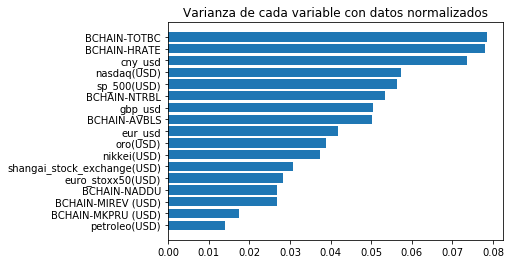

In [24]:
plot_var(variance, 'Varianza de cada variable con datos normalizados')

### Si ahora visualizamos la varianza de los datos sin tomar en cuenta la normalización

Como podemos ver, en general varian más aquellas que nos brindan información del blockchain, sin ambargo, las variables se pueden dividir en tres grupos, las que tienen mayor varianza, aquellas que tienen varianza aceptable, y finalmente las que no varían demasiado.

En el primer grupo tenemos:

    1. BCHAIN-TOTBC: Total de bitcoins disponibles
    2. BCHAIN-MIREV: Recompensas por bloques de monedas y tarifas de transacción pagadas a los mineros
    3. BCHAIN-HRATE: Número estimado de Tera de hashes por segundo que realizan todos los mineros
    4. BCHAIN-NADDU: Número total de un Bitcoin único
    
En el segundo:

    1. nikkei: Es el índice bursatil mas popular del mercado japones
    2. sp_500: El ındice Standard Poor’s 500 es uno de los ındices bursatiles más importantes de Estados Unidos (se lo considera el ındice más representativo de la situación real del mercado)
    3. euro_stoxx50: Representa el rendimiento de las 50 empresas más grandes entre los 19 supersectores en términos de capitalización de mercado en 11 países de la eurozona
    4. BCHAIN-MKPRU: Precio del bitcoin en dolares
    5. oro
    6. BCHAIN-NTRBL: Número de transacciones de Bitcoin por bloque
    7. nasdaq: Segunda bolsa de valores automatizada y electrónica más grande de los Estados Unidos, siendo la primera la Bolsa de Nueva York
    8. petroleo
    9. dow: Índice de mercado de valores ponderado que mide el desempeño de las 30 compañías públicas más grandes cotizadas en la Bolsa de Nueva York.  Las 30 acciones en su lista puedendictar el movimiento de todo el mercado de valores
    10. BCHAIN-ATRCT: Tiempo medio de confirmación de transacción
    
Y finalmente, aquellas que no tienen una varianza significativa:

    1. shangai_stock_exchange: Mercado de valores más grande en China continental
    2. gbp_usd: Tipo de cambio entre libras esterlinas y el dólar
    3. BCHAIN-AVBLS: Tamaño promedio del bloque
    4. eur_usd: Tipo de cambio entre euros y dólar
    5. cny_usd: Tipo de cambio entre el Yuan chino y el dólar

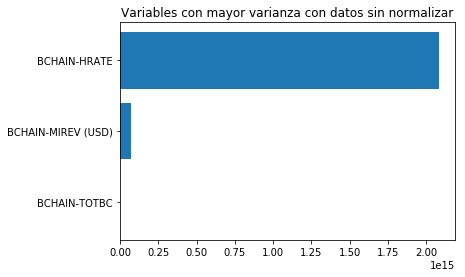

In [25]:
variance = get_variance(complete)
group1 = variance[15:]
plot_var(group1, 'Variables con mayor varianza con datos sin normalizar')

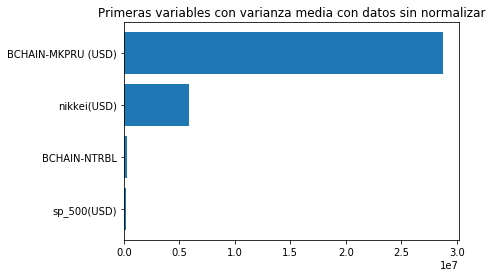

In [26]:
group2 = variance[10:14]
plot_var(group2, 'Primeras variables con varianza media con datos sin normalizar')

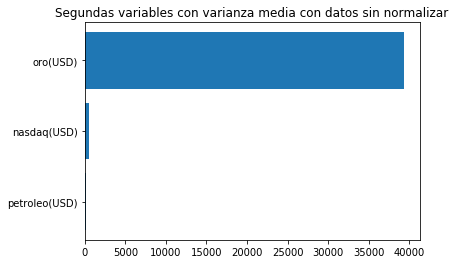

In [27]:
group_22 = variance[6:9]
plot_var(group_22, 'Segundas variables con varianza media con datos sin normalizar')

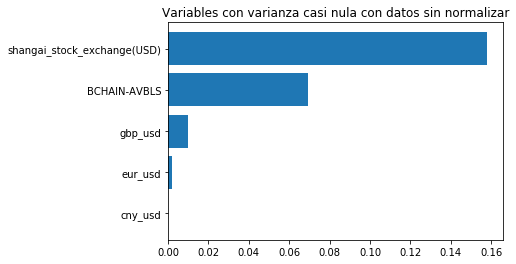

In [28]:
group3 = variance[:5]
plot_var(group3, 'Variables con varianza casi nula con datos sin normalizar')

In [29]:
complete2 = complete.set_index('date', inplace = False)
complete2.head()

,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU,eur_usd,cny_usd,gbp_usd,BCHAIN-MKPRU (USD)
date,,,,,,,,,,,,,,,,,,
2015-01-04,48.03,3688.18,50.64,19129.75,1184.1,53.73,3.58,2067.63,13727150.0,0.413363,761422.01,303832.201585,824.0,212403.0,1.1789,0.16140,1.5236,218.11
2015-01-05,51.26,3615.59,48.84,19510.85,1294.2,47.55,4.20,2087.38,13730725.0,0.382308,768009.00,325690.633354,731.0,219873.0,1.1633,0.16140,1.5185,205.35
2015-01-06,52.07,3582.08,52.05,20444.54,1266.1,59.79,3.85,2108.64,13734300.0,0.366155,677501.44,299460.515231,633.0,254267.0,1.1633,0.16140,1.5185,197.12
2015-01-07,51.66,3444.20,48.80,20291.05,1280.4,60.29,2.90,2067.00,13738025.0,0.330078,789179.66,325690.633354,703.0,223392.0,1.1592,0.16105,1.5177,211.18
2015-01-09,42.33,3238.95,50.09,18763.72,1268.5,58.98,3.09,1970.09,13741900.0,0.343386,826197.10,338805.692415,740.0,197559.0,1.1551,0.16070,1.5169,212.39


In [30]:
complete.tail()

,date,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU,eur_usd,cny_usd,gbp_usd,BCHAIN-MKPRU (USD)
2188,2021-01-02,55.47,3565.71,130.0,27559.1,1901.6,48.35,4.18,3733.27,18596756.25,1.282691,4.317135e+07,1.628797e+08,2087.201258,768365.0,1.2216,0.1532,1.36720,40240.72
2189,2021-01-03,55.47,3565.71,130.0,27559.1,1901.6,48.35,4.18,3733.27,18597631.25,1.337252,3.769767e+07,1.577576e+08,2168.558442,801285.0,1.2212,0.1541,1.36695,38240.09
2190,2021-01-04,55.47,3565.71,130.0,27559.1,1901.6,48.35,4.18,3733.27,18598512.50,1.324212,3.853470e+07,1.516112e+08,2274.506757,796457.0,1.2208,0.1550,1.36670,35544.94
2191,2021-01-05,55.47,3565.71,130.0,27559.1,1901.6,48.35,4.18,3733.27,18599606.25,1.264866,3.749372e+07,1.557088e+08,2099.782895,772596.0,1.2157,0.1546,1.36400,34011.82
2192,2021-01-06,55.47,3565.71,130.0,27559.1,1901.6,48.35,4.18,3733.27,18600481.25,1.296483,4.251814e+07,1.505868e+08,2304.823129,802110.0,1.2151,0.1545,1.36830,37393.13


In [31]:
def plot_serie(df, start, end, col, size):
    '''
    Gráfica los valores deseados respecto al tiempo
    
    Params:
        df: DataFrame de python con índice dependiente del tiempo
        start: fecha de inicio del período a gráficar
        end: fecha de terminó del período a gráficar
        col: columna que se desea gráficar
        size: tramaño de la gráfica
    '''
    start1 = start.split('-')
    end1 = end.split('-')
    start_date = datetime(int(start1[0]), int(start1[1]), int(start1[2]))
    end_date = datetime(int(end1[0]), int(end1[1]), int(end1[2]))
    df = df[(df.index >= start_date) & (df.index <= end_date)]
    matplotlib.rcParams['figure.figsize'] = size
    plt.grid(True)
    plt.plot(df.index, df[col], c = 'dodgerblue')
    plt.title(f'Historico de {col}, desde {start} hasta {end}')

### Gráficas 

Si consideramos la gráfica de varianzas con datos normalizados, es la variable que tiene mayor varianza es BCHAIN-TOTBC:

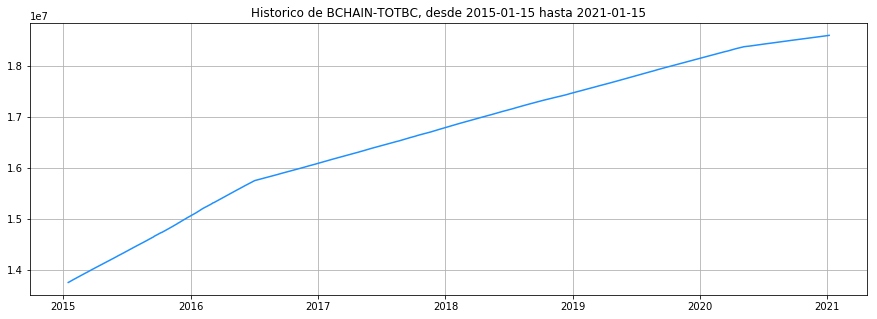

In [32]:
plot_serie(complete2, start, end, 'BCHAIN-TOTBC', (15, 5))

Ahora veamos, nuestra variable de interés que es el precio del bitcoin, como podemos ver, no es tan variable hasta mediados de 2017 que comienza a crecer el valor manteniendose "constante", el pediodo de 2018 a 2021 es el interesante.

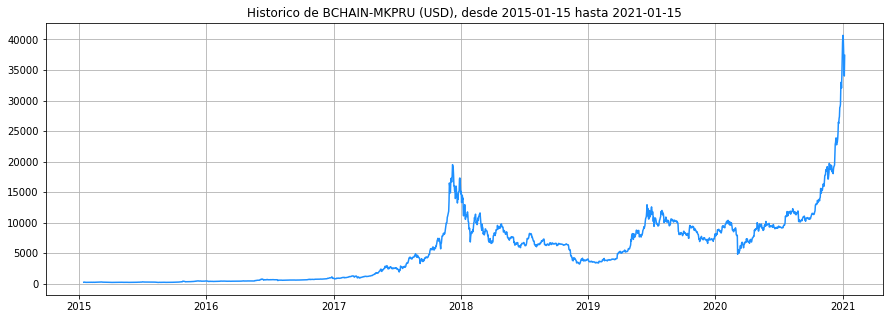

In [33]:
plot_serie(complete2, start, end, 'BCHAIN-MKPRU (USD)', (15, 5))

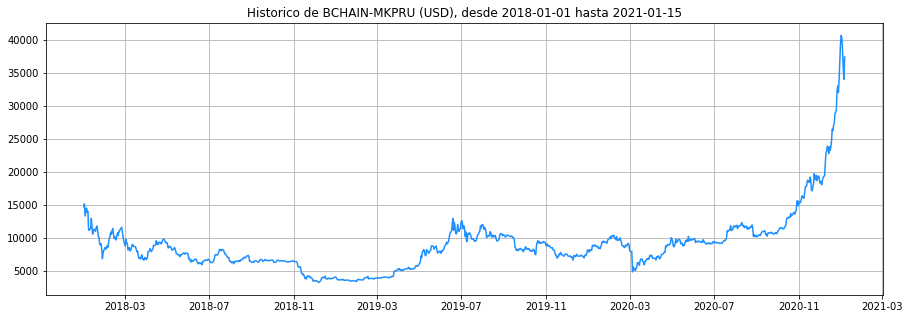

In [34]:
start= '2018-01-01'
end='2021-01-15'
plot_serie(complete2, start, end, 'BCHAIN-MKPRU (USD)', (15, 5))

### Correlaciones entre variables
No olvidemos que uno de nuestros objetivos es ver que variables estan relacionadas con el precio del bitcoin.

In [35]:
import seaborn as sns

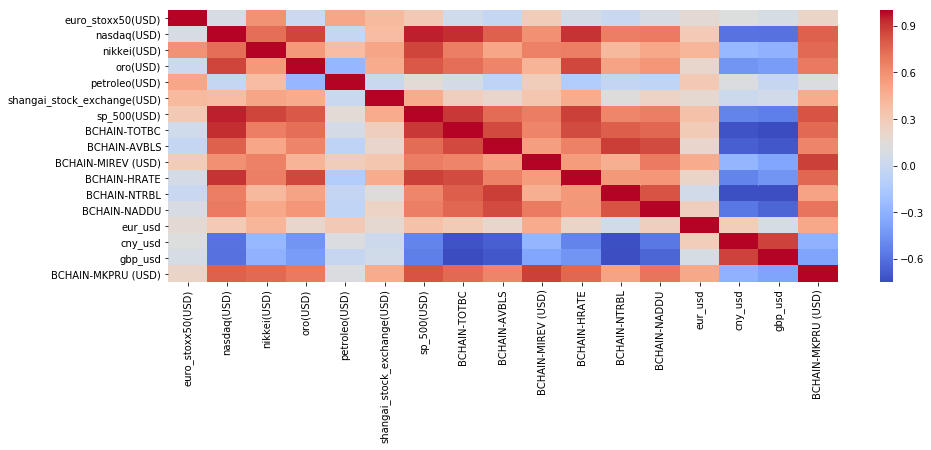

In [36]:
# matriz de correlación con datos normalizados
corr = complete_norm.iloc[:,1:].corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = 'coolwarm')

Como simplemente nos interesa el precio del bitcoin, realizaremos un analisis sobre esta, a continuación se muestra una grafica más representativa de las variables que estan mayormente correlacionadas.

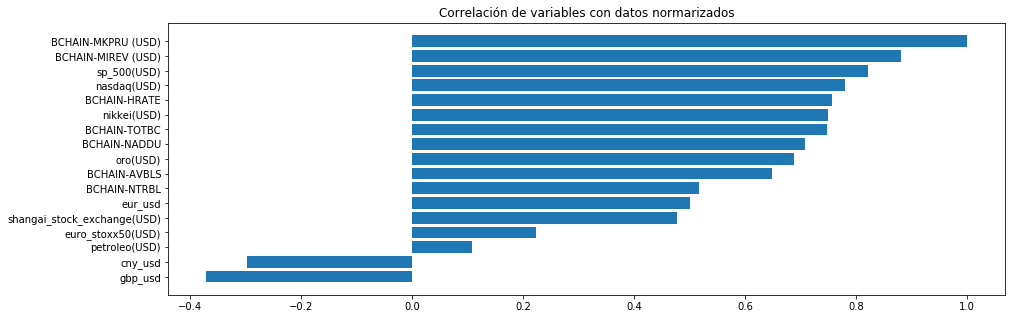

In [37]:
corr_c = list(corr.columns)
corr_v = corr.iloc[:,-1]
corr = [(corr_c[i],corr_v[i]) for i in range(0,len(corr_v))]
corr.sort(key = lambda c: c[1])
plot_var(corr, 'Correlación de variables con datos normarizados')

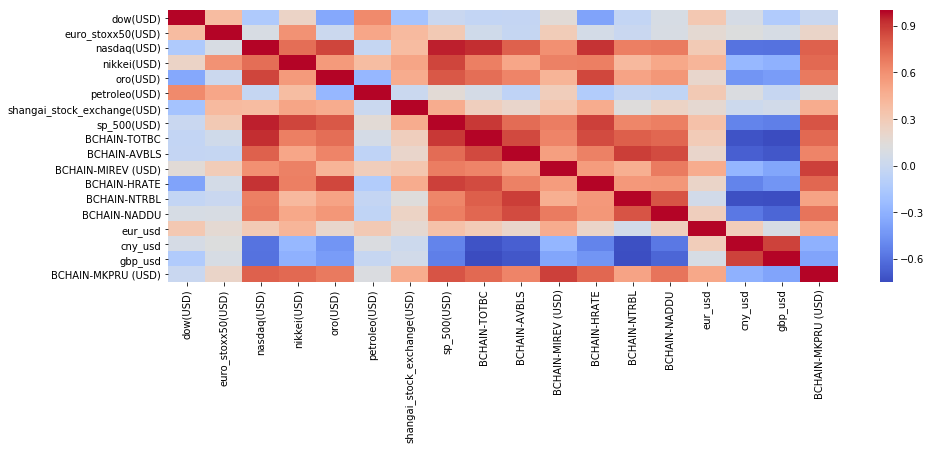

In [38]:
# matriz de correlación con datos normalizados
corr = complete.iloc[:,1:].corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = 'coolwarm')

In [39]:
corr_c = list(corr.columns)
corr_c.remove('BCHAIN-MKPRU (USD)')
corr_v = list(corr.iloc[:,-1])
corr_v.pop()

1.0

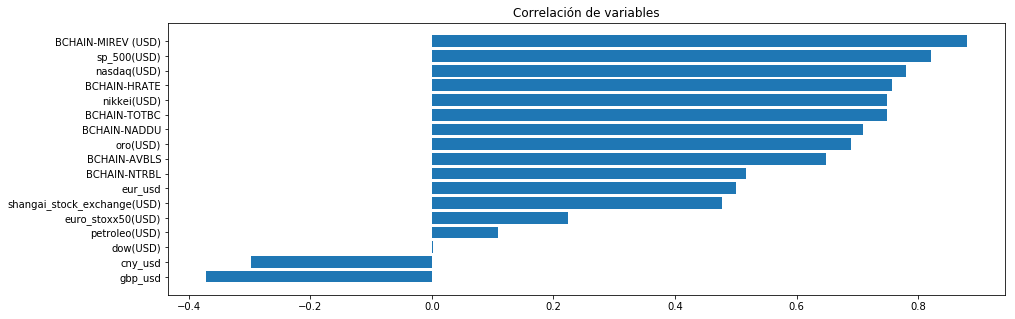

In [40]:
corr = [(corr_c[i],corr_v[i]) for i in range(0,len(corr_v))]
corr.sort(key = lambda c: c[1])
plot_var(corr, 'Correlación de variables')

Ya que hemos visto que tan correlacionadas estan las variables podemos comparar las gráficas de aquellas que tienen una alta correlacion con el precio del bitcoin. 

Si recordamos BCHAIN-AVBLS, o el tamaño promedio del bloque, no tiene una varianza tan alta sin embargo esta mas correlacionada con nuestra variable de interes que aquellas con una varianza mayor.

Y recordemos el significado de las variables:

In [41]:
bit

{'BCHAIN-TOTBC': 'Total de bitcoins disponibles',
 'BCHAIN-MKPRU': 'Precio del bitcoin en dolares',
 'BCHAIN-AVBLS': 'Tamaño promedio del bloque',
 'BCHAIN-MIREV': 'Recompensas por bloques de monedas y tarifas de transacción pagadas a los mineros',
 'BCHAIN-HRATE': 'Número estimado de Tera de hashes por segundo que realizan todos los mineros',
 'BCHAIN-NTRBL': 'Número de transacciones de Bitcoin por bloque',
 'BCHAIN-NADDU': 'Número total de un Bitcoin único'}

Como podemos ver a continuación las gráficas del precio del bitcoin y la recompeza de los mineros son muy parecidas

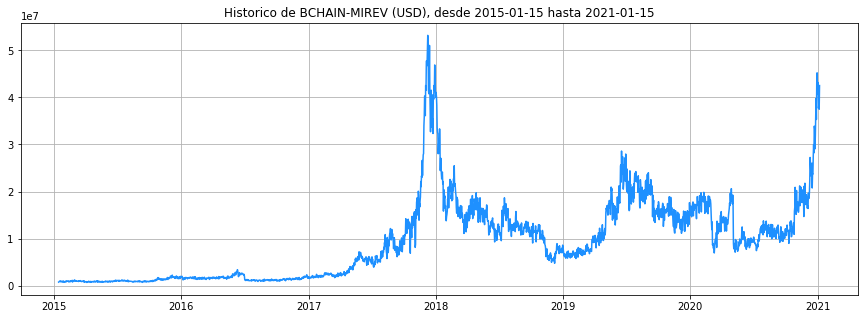

In [42]:
start= '2015-01-15'
end='2021-01-15'
plot_serie(complete2, start, end, 'BCHAIN-MIREV (USD)', (15, 5))

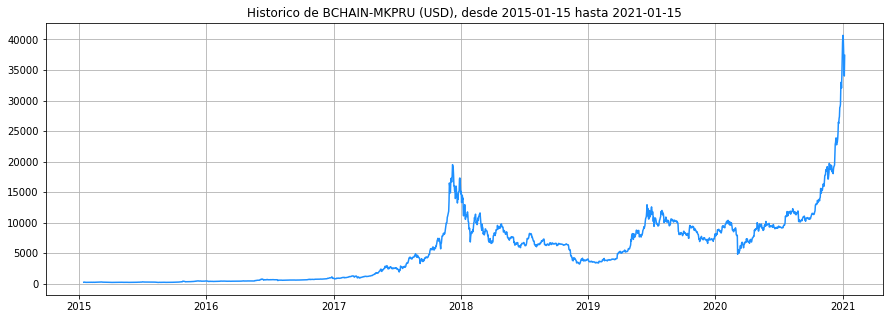

In [43]:
plot_serie(complete2, start, end, 'BCHAIN-MKPRU (USD)', (15, 5))

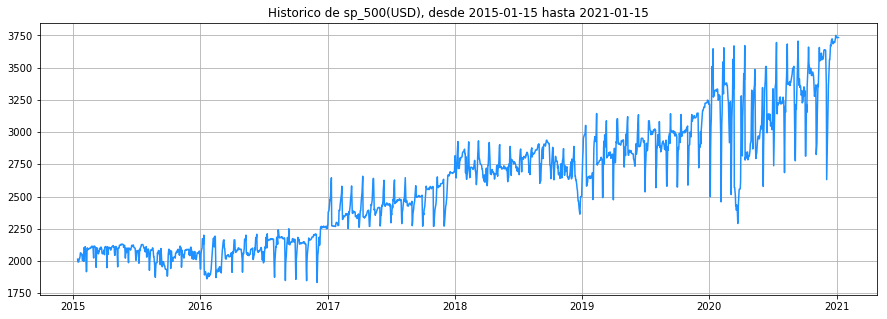

In [44]:
plot_serie(complete2, start, end, 'sp_500(USD)', (15, 5))

A pesar de que la grafica de sp_500 (Índice Standard Poor’s 500 es uno de los ́ındices bursatiles mas importantes de Estados Unidos, se lo considera el ́ındice mas representativo de la situacion real del mercado) no es tan parecida a la del bitcoin, se puede ver que siguen una tendencia parecida.

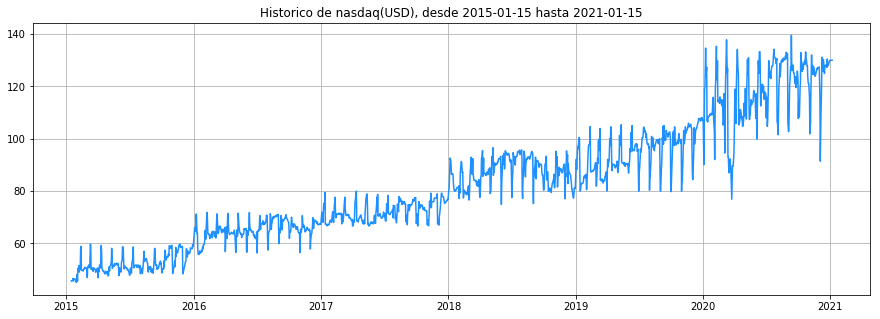

In [45]:
plot_serie(complete2, start, end, 'nasdaq(USD)', (15, 5))

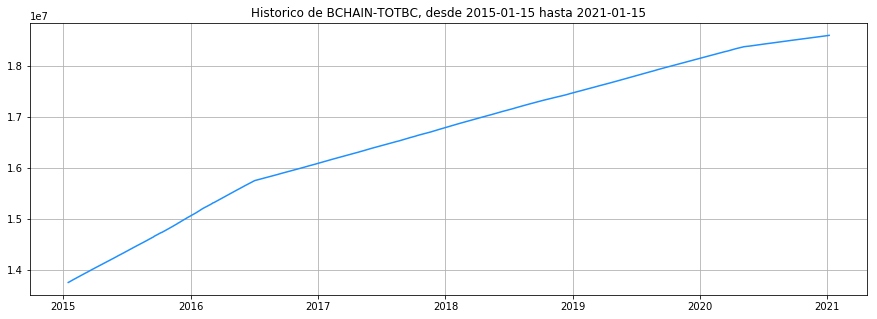

In [46]:
plot_serie(complete2, start, end, 'BCHAIN-TOTBC', (15, 5))

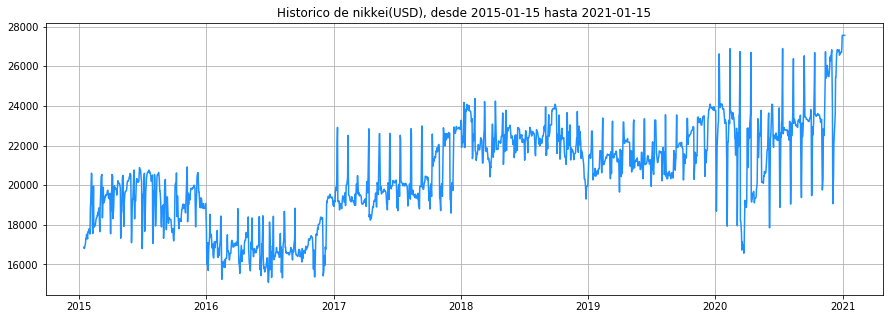

In [47]:
plot_serie(complete2, start, end, 'nikkei(USD)', (15, 5))

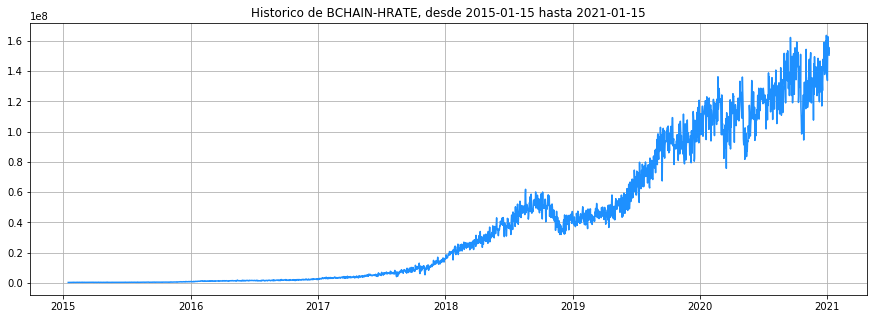

In [48]:
plot_serie(complete2, start, end, 'BCHAIN-HRATE', (15, 5))

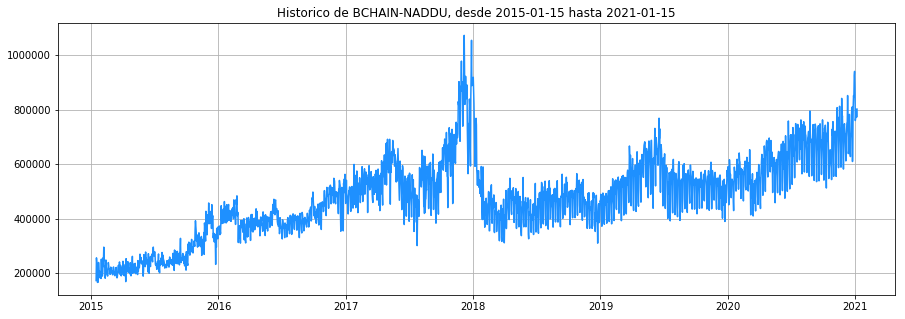

In [49]:
plot_serie(complete2, start, end, 'BCHAIN-NADDU', (15, 5))

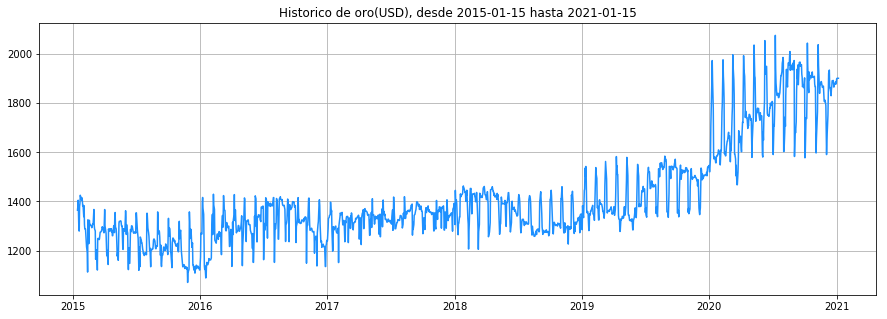

In [50]:
plot_serie(complete2, start, end, 'oro(USD)', (15, 5))

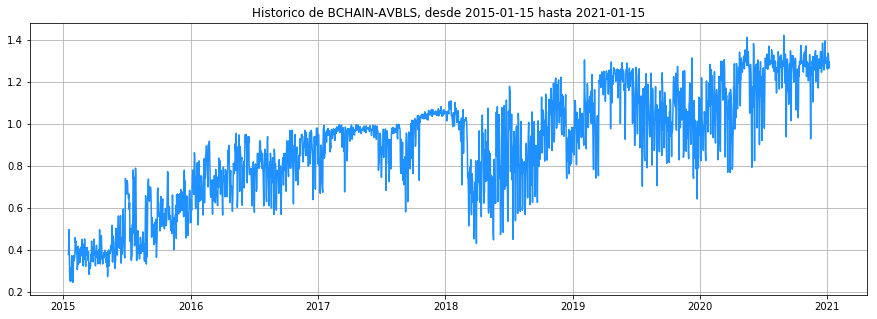

In [51]:
plot_serie(complete2, start, end, 'BCHAIN-AVBLS', (15, 5))

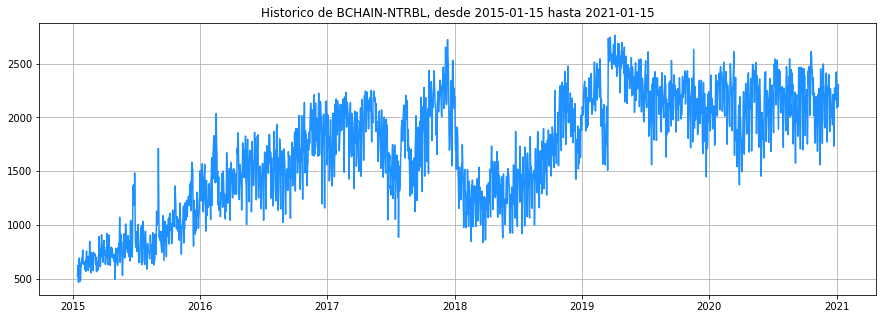

In [52]:
plot_serie(complete2, start, end, 'BCHAIN-NTRBL', (15, 5))

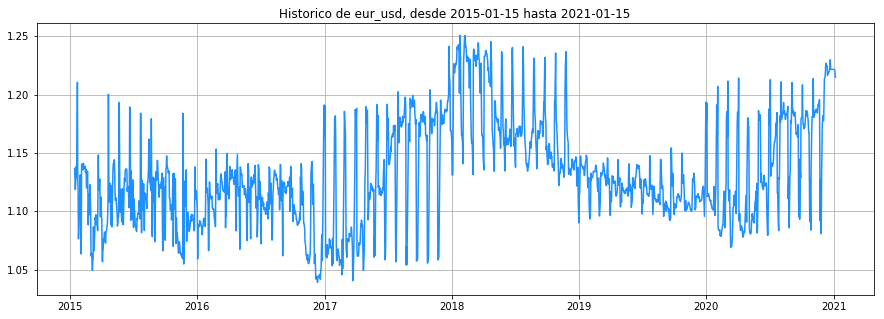

In [53]:
plot_serie(complete2, start, end, 'eur_usd', (15, 5))

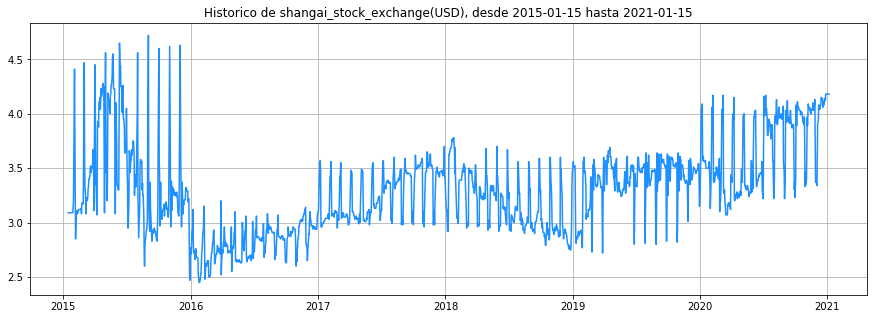

In [54]:
plot_serie(complete2, start, end, 'shangai_stock_exchange(USD)', (15, 5))

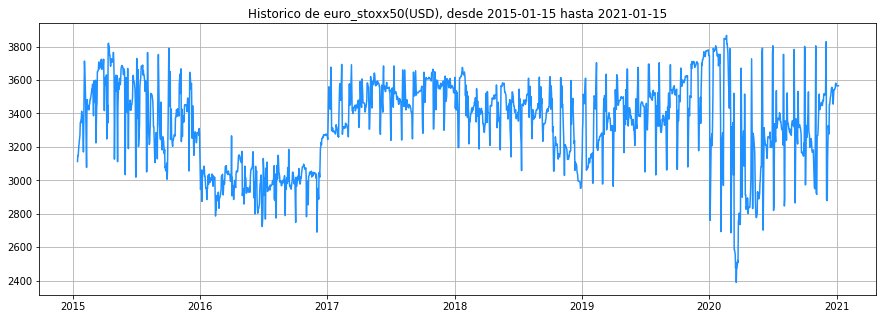

In [55]:
plot_serie(complete2, start, end, 'euro_stoxx50(USD)', (15, 5))

Como se puede observar en las graficas anteriores, y como era de esperarse, aquellas variables con una correlación mayor al precio del bitcoin siguen una tendencia igual, y conforme se avanza hacía aquellas con menor correlación encontramos mas volatilidad y con ello más ruido.

Las siguientes dos gráficas muestran aquellas variables que tienen una relación negativa.

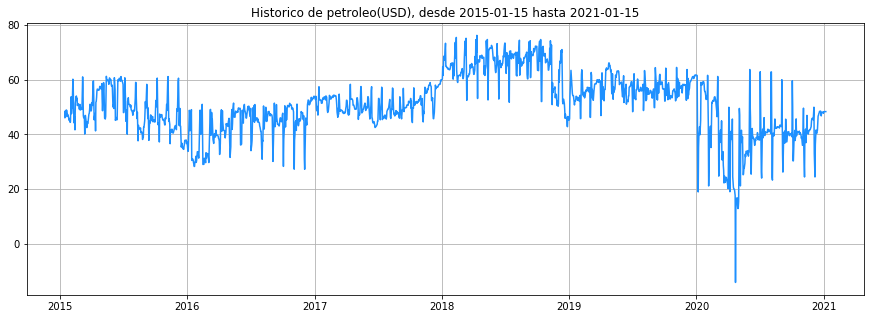

In [56]:
plot_serie(complete2, start, end, 'petroleo(USD)', (15, 5))

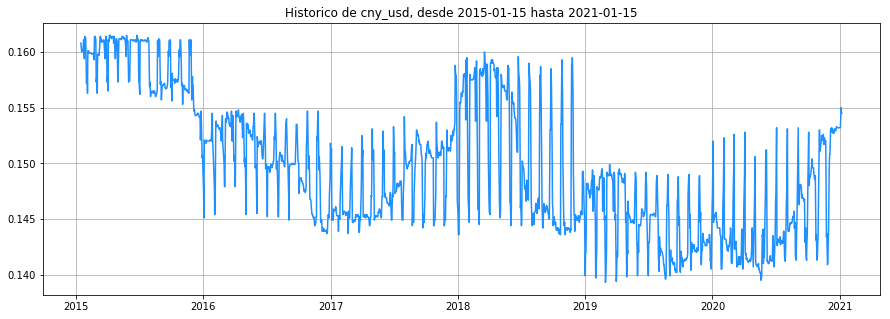

In [57]:
plot_serie(complete2, start, end, 'cny_usd', (15, 5))

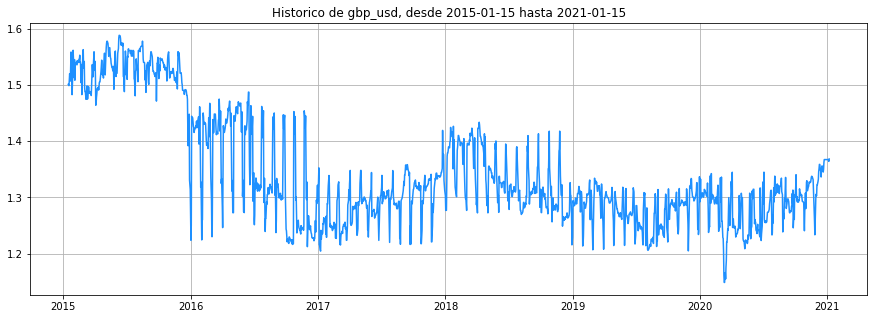

In [58]:
plot_serie(complete2, start, end, 'gbp_usd', (15, 5))